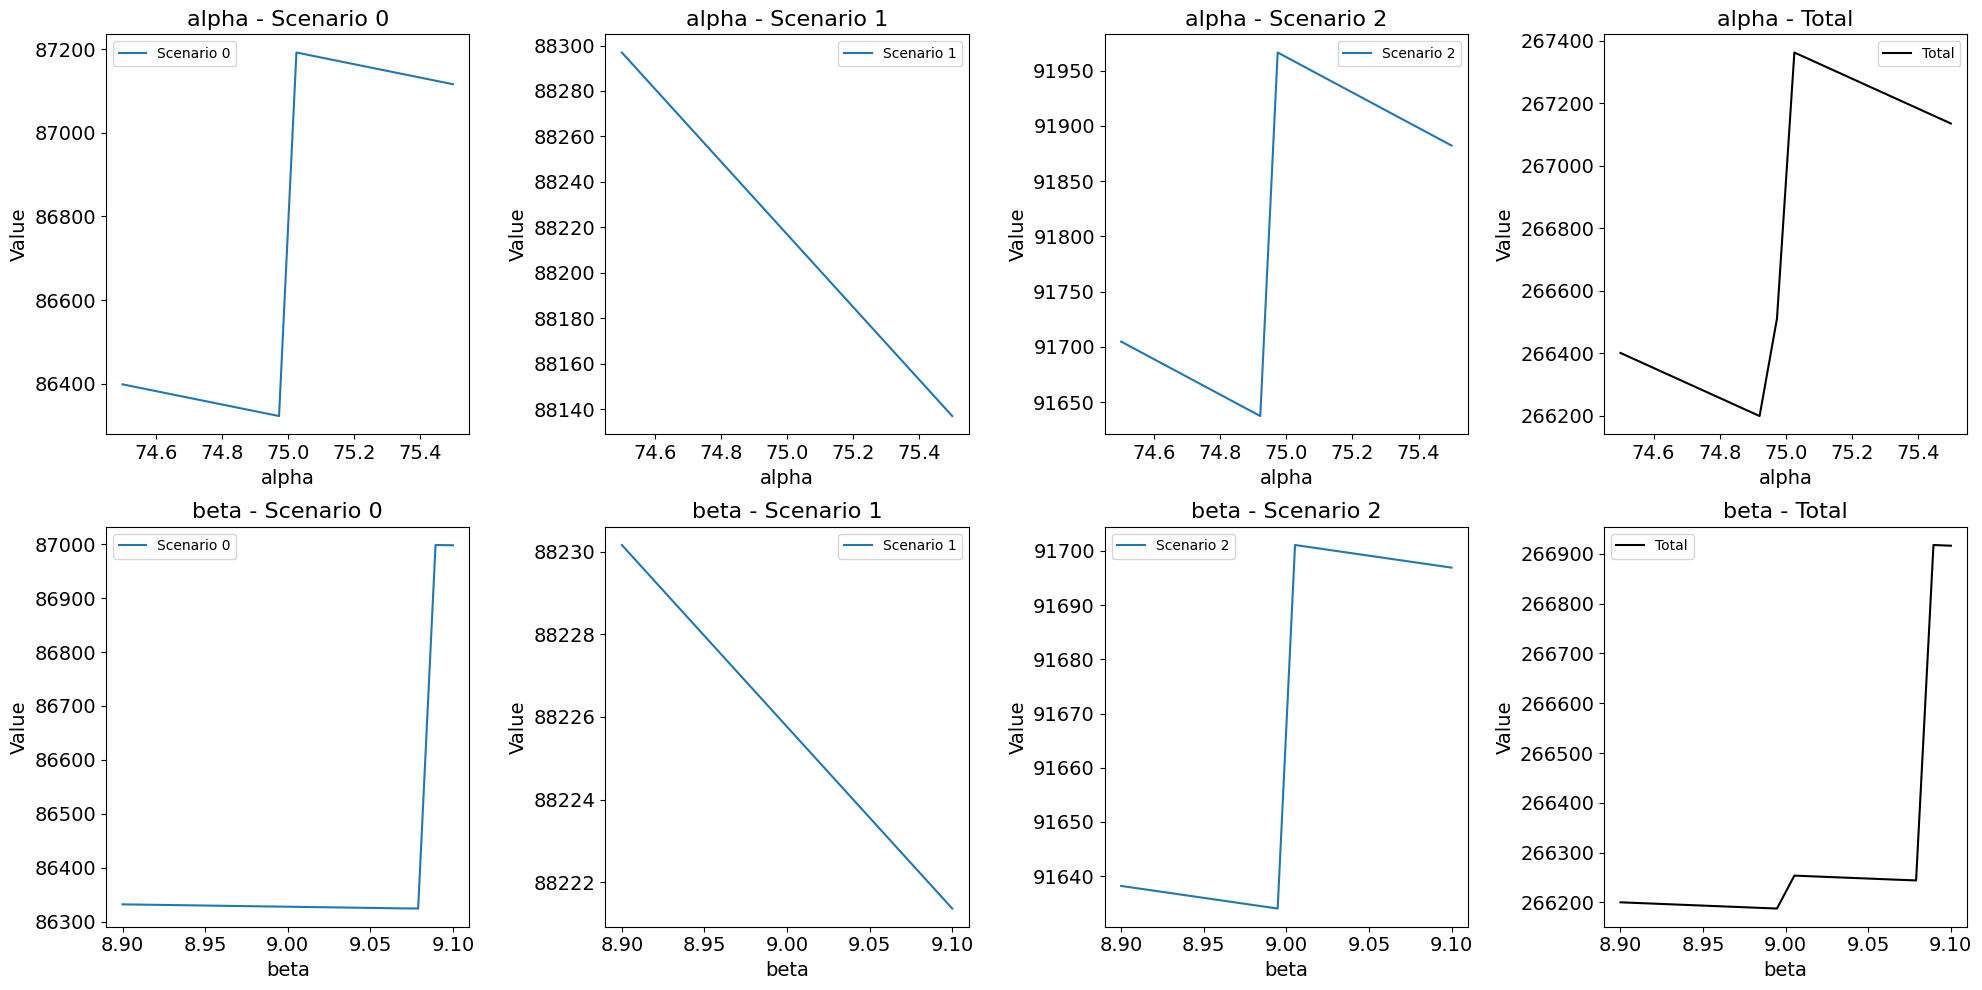

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyomo.opt import SolverFactory, TerminationCondition
from src.analyses.value_function import ValueFunction
from src.analyses.convergence_analysis import HausdorffAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from scipy.optimize import curve_fit
from NSPLIB.src.instances.poutil.poutil_SP import const_model
import copy
# Constants
poutil_obj = 266187.5332404778  # Replace with actual value
poutil_sol = {'alpha': 74.94473247856709, 'beta': 9.000000000000028}  
poutil_y_bound = {'alpha': [0.0, 470], 'beta': [0.0, 470]}  
poutil_y_bound = {'alpha': [74.5, 75.5], 'beta': [8.9, 9.1]}  # Adjusted bounds for better visualization
# Build model
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()

v_f= ValueFunction(m,solver="baron")
y_dimension = {
    'alpha': {}, 'beta': {}
}
steps=20
for y in y_dimension.keys():
    v_f.calc_1D(idx=y, y_val_fix=copy.deepcopy(poutil_sol),
                    interval=poutil_y_bound[y], step=steps)
    for s in m.scenarios:
        y_dimension[y][s] = v_f.value_func[s]
    y_dimension[y]['total'] = v_f.total_value_func


fig, axs = plt.subplots(
    nrows=len(y_dimension), 
    ncols=len(m.scenarios) + 1, 
    figsize=(5 * (len(m.scenarios) + 1), 5 * len(y_dimension))
)
for row_idx, (y_key, y_data) in enumerate(y_dimension.items()):
    for col_idx, s in enumerate(m.scenarios):
        ax = axs[row_idx, col_idx] if len(y_dimension) > 1 else axs[col_idx]
        ax.plot(
            np.linspace(*poutil_y_bound[y_key], steps), 
            y_data[s], 
            label=f"Scenario {s}"
        )
        ax.set_title(f"{y_key} - Scenario {s}", fontsize=16)
        ax.set_xlabel(y_key, fontsize=14)
        ax.set_ylabel("Value", fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
        ax.legend()
    # Plot total in the last column
    ax = axs[row_idx, -1] if len(y_dimension) > 1 else axs[-1]
    ax.plot(
        np.linspace(*poutil_y_bound[y_key], steps), 
        y_data['total'], 
        label="Total", color='black'
    )
    ax.set_title(f"{y_key} - Total", fontsize=16)
    ax.set_xlabel(y_key, fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend()

plt.tight_layout()
plt.show()